In [1]:
from google.colab import drive
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.transforms import ToTensor
import os 
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt
import time
import torch.optim as optim
import numpy as np
import torchvision
from torch.cuda import device    
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import warnings
from tqdm import tqdm
from torchvision import transforms
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns
warnings.filterwarnings("ignore")


In [2]:
drive.mount('/content/drive/')
%cd /content/drive/My Drive/


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive


In [3]:
data_transforms = transforms.Compose([
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.4960, 0.4960, 0.4960],
                          std=[0.2540, 0.2540, 0.2540]),
])

batch_size = 128
num_workers = 4


train_dir = '/content/drive/My Drive/Colab Notebooks/mydataset/Datasets/FER2013/train'
test_dir = '/content/drive/My Drive/Colab Notebooks/mydataset/Datasets/FER2013/test'
val_dir = '/content/drive/My Drive/Colab Notebooks/mydataset/Datasets/FER2013/validation'


train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)


In [4]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

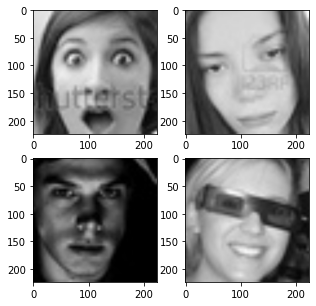

In [5]:
plot_data_loader(train_loader, (2, 2))

In [6]:
num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)

Number of classes: 3


In [7]:
torch.cuda.empty_cache()

In [8]:
train_size = len(train_dataset)
test_size = len(test_dataset)
val_size = len(val_dataset)
print("Train Size:",train_size)
print("Test Size:",test_size)
print("Validation Size:",val_size)

Train Size: 3208
Test Size: 1006
Validation Size: 761


In [9]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Linear(num_ftrs, len(train_dataset.classes))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Device: {}".format(device))

num_epochs = 25

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


Device: cuda:0


In [10]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc

In [11]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
    return epoch_loss, epoch_acc

In [12]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):

    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = test_model(model, val_loader, criterion, device)
    
    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            pbar.update(1)


Epoch 1/25 | Train Loss: 1.0598 | Train Acc: 0.4383 | Val Loss: 1.3463 | Val Acc: 0.2917


Epoch 1/25: 100%|██████████| 26/26 [00:13<00:00,  1.87batch/s]


Epoch 2/25 | Train Loss: 1.1536 | Train Acc: 0.4280 | Val Loss: 1.1897 | Val Acc: 0.3548


Epoch 2/25: 100%|██████████| 26/26 [00:14<00:00,  1.81batch/s]


Epoch 3/25 | Train Loss: 1.0626 | Train Acc: 0.4726 | Val Loss: 1.1300 | Val Acc: 0.4586


Epoch 3/25: 100%|██████████| 26/26 [00:14<00:00,  1.85batch/s]


Epoch 4/25 | Train Loss: 1.0799 | Train Acc: 0.4620 | Val Loss: 1.0641 | Val Acc: 0.4691


Epoch 4/25: 100%|██████████| 26/26 [00:14<00:00,  1.75batch/s]


Epoch 5/25 | Train Loss: 1.0532 | Train Acc: 0.4676 | Val Loss: 1.5535 | Val Acc: 0.3837


Epoch 5/25: 100%|██████████| 26/26 [00:13<00:00,  1.87batch/s]


Epoch 6/25 | Train Loss: 0.9570 | Train Acc: 0.5277 | Val Loss: 1.8881 | Val Acc: 0.3548


Epoch 6/25: 100%|██████████| 26/26 [00:13<00:00,  1.86batch/s]


Epoch 7/25 | Train Loss: 0.9784 | Train Acc: 0.5390 | Val Loss: 0.8282 | Val Acc: 0.6189


Epoch 7/25: 100%|██████████| 26/26 [00:14<00:00,  1.83batch/s]


Epoch 8/25 | Train Loss: 1.0250 | Train Acc: 0.4757 | Val Loss: 0.9230 | Val Acc: 0.5361


Epoch 8/25: 100%|██████████| 26/26 [00:14<00:00,  1.79batch/s]


Epoch 9/25 | Train Loss: 0.7485 | Train Acc: 0.6808 | Val Loss: 0.9530 | Val Acc: 0.5519


Epoch 9/25: 100%|██████████| 26/26 [00:14<00:00,  1.76batch/s]


Epoch 10/25 | Train Loss: 0.8443 | Train Acc: 0.6272 | Val Loss: 0.7454 | Val Acc: 0.6833


Epoch 10/25: 100%|██████████| 26/26 [00:14<00:00,  1.85batch/s]


Epoch 11/25 | Train Loss: 0.6501 | Train Acc: 0.7307 | Val Loss: 1.1014 | Val Acc: 0.5572


Epoch 11/25: 100%|██████████| 26/26 [00:14<00:00,  1.80batch/s]


Epoch 12/25 | Train Loss: 0.5689 | Train Acc: 0.7684 | Val Loss: 0.6674 | Val Acc: 0.7398


Epoch 12/25: 100%|██████████| 26/26 [00:14<00:00,  1.80batch/s]


Epoch 13/25 | Train Loss: 0.5214 | Train Acc: 0.7927 | Val Loss: 0.7004 | Val Acc: 0.7227


Epoch 13/25: 100%|██████████| 26/26 [00:14<00:00,  1.75batch/s]


Epoch 14/25 | Train Loss: 0.4263 | Train Acc: 0.8392 | Val Loss: 0.6784 | Val Acc: 0.7306


Epoch 14/25: 100%|██████████| 26/26 [00:13<00:00,  1.86batch/s]


Epoch 15/25 | Train Loss: 0.3188 | Train Acc: 0.8850 | Val Loss: 0.8586 | Val Acc: 0.7030


Epoch 15/25: 100%|██████████| 26/26 [00:14<00:00,  1.82batch/s]


Epoch 16/25 | Train Loss: 0.3610 | Train Acc: 0.8572 | Val Loss: 1.0069 | Val Acc: 0.6597


Epoch 16/25: 100%|██████████| 26/26 [00:14<00:00,  1.80batch/s]


Epoch 17/25 | Train Loss: 0.3001 | Train Acc: 0.8878 | Val Loss: 0.7409 | Val Acc: 0.7490


Epoch 17/25: 100%|██████████| 26/26 [00:14<00:00,  1.76batch/s]


Epoch 18/25 | Train Loss: 0.1892 | Train Acc: 0.9336 | Val Loss: 0.7717 | Val Acc: 0.7543


Epoch 18/25: 100%|██████████| 26/26 [00:14<00:00,  1.84batch/s]


Epoch 19/25 | Train Loss: 0.1799 | Train Acc: 0.9386 | Val Loss: 0.6777 | Val Acc: 0.7845


Epoch 19/25: 100%|██████████| 26/26 [00:14<00:00,  1.84batch/s]


Epoch 20/25 | Train Loss: 0.1782 | Train Acc: 0.9355 | Val Loss: 0.8727 | Val Acc: 0.7162


Epoch 20/25: 100%|██████████| 26/26 [00:14<00:00,  1.81batch/s]


Epoch 21/25 | Train Loss: 0.1531 | Train Acc: 0.9498 | Val Loss: 1.0575 | Val Acc: 0.7175


Epoch 21/25: 100%|██████████| 26/26 [00:14<00:00,  1.75batch/s]


Epoch 22/25 | Train Loss: 0.1567 | Train Acc: 0.9464 | Val Loss: 0.8462 | Val Acc: 0.7543


Epoch 22/25: 100%|██████████| 26/26 [00:13<00:00,  1.88batch/s]


Epoch 23/25 | Train Loss: 0.0433 | Train Acc: 0.9891 | Val Loss: 0.8927 | Val Acc: 0.7661


Epoch 23/25: 100%|██████████| 26/26 [00:14<00:00,  1.83batch/s]


Epoch 24/25 | Train Loss: 0.0213 | Train Acc: 0.9953 | Val Loss: 0.9425 | Val Acc: 0.7911


Epoch 24/25: 100%|██████████| 26/26 [00:14<00:00,  1.77batch/s]


Epoch 25/25 | Train Loss: 0.0561 | Train Acc: 0.9816 | Val Loss: 1.0306 | Val Acc: 0.7503


Epoch 25/25: 100%|██████████| 26/26 [00:14<00:00,  1.76batch/s]


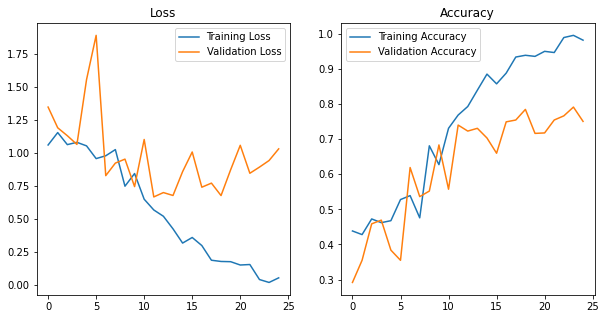

In [16]:
train_accs=torch.tensor(train_accs)
val_accs = torch.tensor(val_accs)  

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(train_losses, label="Training Loss")
axs[0].plot(val_losses, label="Validation Loss")
axs[0].set_title("Loss")
axs[0].legend()

val_accs = val_accs.cpu().numpy()  
axs[1].plot(train_accs, label="Training Accuracy")
axs[1].plot(val_accs, label="Validation Accuracy")
axs[1].set_title("Accuracy")
axs[1].legend()

plt.show()


Test Accuracy of the model on the 1006 test images: 71.76938369781311 %


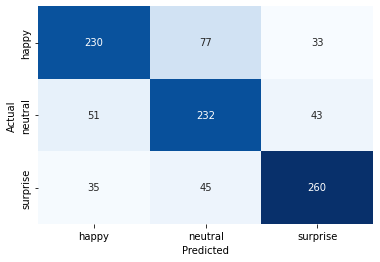

In [14]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    for data in test_loader:
        images, labels = data[0].to(torch.device('cuda:0')), data[1].to(torch.device('cuda:0'))
        #images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predicted += predicted.tolist()
        all_labels += labels.tolist()

    print('Test Accuracy of the model on the {} test images: {} %'
          .format(total, (correct / total) * 100))

    cm = confusion_matrix(all_labels, all_predicted)
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                     xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')


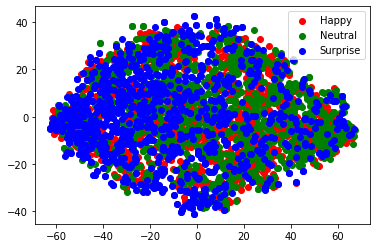

In [17]:
label_names = ['Happy', 'Neutral', 'Surprise']
colors = ['r', 'g', 'b']

mobilenetv2 = models.mobilenet_v2(pretrained=False)
mobilenetv2 = torch.nn.Sequential(*list(mobilenetv2.children())[:-1])
mobilenetv2.eval()


features = []
labels = []
with torch.no_grad():
    for images, target in train_loader:
        outputs = mobilenetv2(images)
        features.append(outputs.view(outputs.size(0), -1).numpy())
        labels.append(target.numpy())
features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, random_state=0)
tsne_features = tsne.fit_transform(features)

for label_id in range(len(label_names)):
    plt.scatter(tsne_features[labels == label_id, 0], tsne_features[labels == label_id, 1], c=colors[label_id], label=label_names[label_id])
plt.legend()
plt.show()

